# 1. Introduction

classification을 위한 이전의 방법들(DCNN, sliding window를 사용한 IDSIA network)은 여러 문제가 있다.


* 이전에 검증한 부분을 다음 과정에서 다시 검증하는 중복이 많아 training 속도가 매우 느리다. 
* localization과 context 사이가 trade off 관계이다.   


U-Net은 적은 데이터를 가지고 정확한 biomedical segmentation을 목적으로 제안된 End-to-End 방식의 Fully-Convolutional Network 기반의 모델이다. 네트워크 구조가 U자 형태이며 이미지의 전반적인 컨텍스트 정보를 얻기 위한 네트워크와 정확한 localization을 위한 네트워크가 대칭 형태로 구성되어 있다. U-Net의 아이디어는 다음과 같다. 

 

1. patch 탐색 방식으로 이전 방법들에 비해 빠른 속도로 훈련 가능
2. up-sampling 연산으로 contracting path의 출력 해상도를 보완   

localization 정확도를 위해, expanding path의 upsampled output과 contracting path의 high resolution feature을 결합한다. 이 결합 정도를 기반으로 연속 컨볼루션 계층에서 더 정밀하게 output을 출력한다. 

이러한 U-net은 up-sampling에서도 많은 수 의 feature channel을 가지고 있어 네트워크가 context정보를 더 높은 해상도 계층으로 전파할 수 있게 한다. 이를 통해 localization과 context 사이 trade off를 해결했다. 따라서 픽셀 별 class 분류가 필요한 Biomedical image 처리에 U-net이 매우 유용하다. 

# 2. Network Architecture

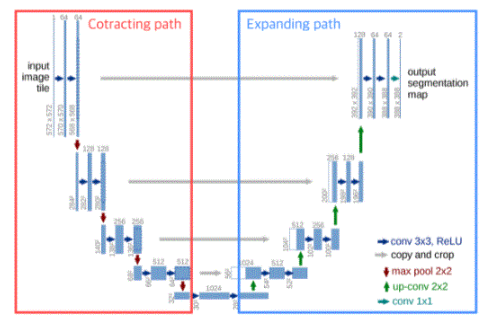

U-Net의 핵심 아이디어는

Contracting path는 이미지의 context를 포착하고, 

Expansive path는 피쳐맵을 up-sampling하고 이를 Contracting path에서 포착한 피쳐맵의 context와 결합하여 더 정확한 Localization을 하는 것이다. 

## Contracting path 
convolution layer의 일반적인 아키텍쳐를 따르는 구조로, 이 부분에서는 입력 이미지의 context 포착을 목적으로 구성되었다. 

이는 해상도는 안좋은 Coarse Map을 생성하지만, Context 및 개체 정보를 잘 포착해서 Sematic에 해당하는 부분이다.

패딩 과정이 없는 2개의 3x3 convolutions + ReLU + down-sampling을 위한 2x2 max pooling operation의 구조가 반복된다. 매 down-sampling 과정마다 feature channel의 수가 2배로 증가한다. 

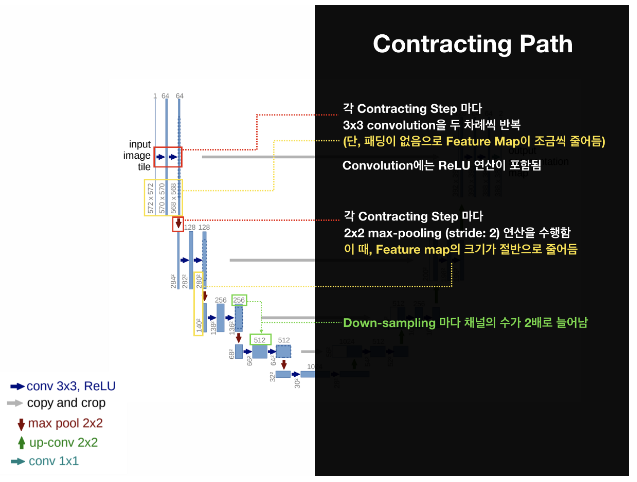

## Expanding path 
세밀한 localization을 위한 구성이다. 높은 차원의 채널을 갖는 up-sampling을 통해 이를 contracting path에서 포착한 feature map의 context와 결합하여 localization을 수행한다. Coarse Map에서 Dense Prediction을 얻기 위한 구조로 Sementation을 위한 정교한 아웃라인을 그리기 위함이다.

2x2 convolution + concatenation + 2개의 3x3 convolutions + ReLU 의 구조가 반복된다. up convolution 과정에서 feature channel 수가 반으로 줄어든다. concatenation 과정은 contracting path의 high resolution featuer를 upsampled output과 합쳐주는 것으로 localize를 위해 수행한다. 그리고 마지막 층에서는 64개의 feature vector의 요소를 클래스 수에 맞추기 위해 1x1 convolution이 사용된다.  

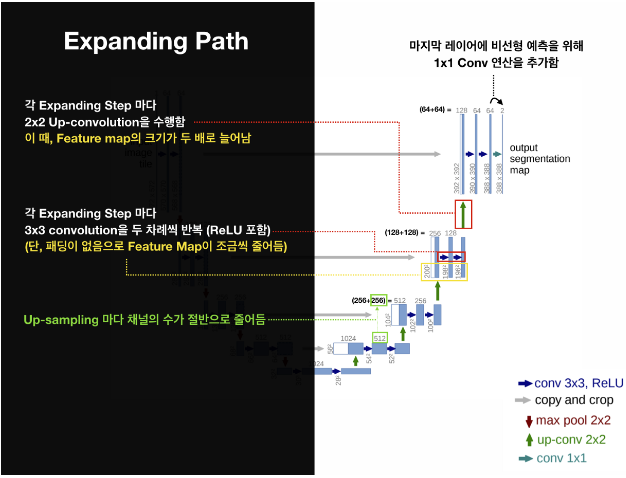

## Overlap-Tile input 
U-net에서는 이미지 전체를 사용하는 대신 overlap-tile 전략을 사용하여 그림처럼 이미지를 patch로 나눠서 입력으로 사용한다. 

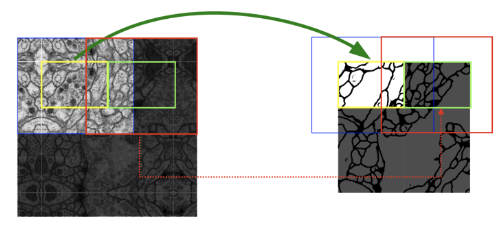

파란 영역의 이미지를 입력하면 노란 영역의 segmentation 결과를 얻는다. 다음 patch에 대한 segmentation을 얻기 위해서는 이전 입력과 어느정도 겹치게 되어 overlap-tile라고 한다. 

이 과정에서 원본 이미지의 경계부분에 segmentation을 위해 패딩 대신 mirroring extrapolation 기법을 사용한다. 

이 기법을 input 이미지에 사용하여 convolution 연산과정에서는 패딩없이 진행한다. 패딩이 없이 input 이미지에 mirroring 기법을 사용하여 output 사이즈가 input 사이즈에 비해 조금 작은 것을 확인할 수 있다.   

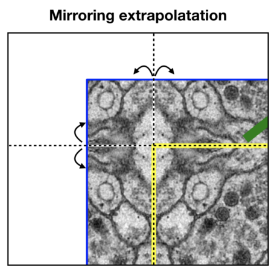

## Touching cells separation

세포 분할(Segmentation) 작업에서 주요한 과제 중 하나는 동일한 클래스의 접촉 개체를 분리하는 것이다.  

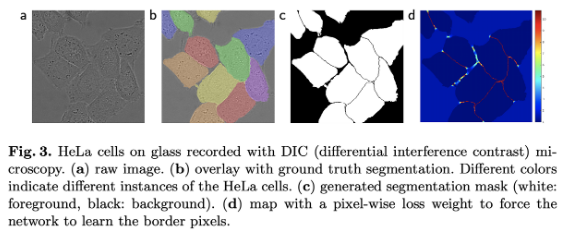  
닿아 있는 세포 사이의 경계부분을 분리하기 위해 사전에 학습된 가중치 맵을 사용한다.  

이미지 c, d와 같이 각 세포 사이의 경계를 포착할 수 있어야 한다.

이를 위해 학습 데이터에서 각 픽셀마다 클래스 분포가 다른 점을 고려하여 사전에 Ground-Truth에 대한 Weight map을 구해 학습에 반영하였다.  

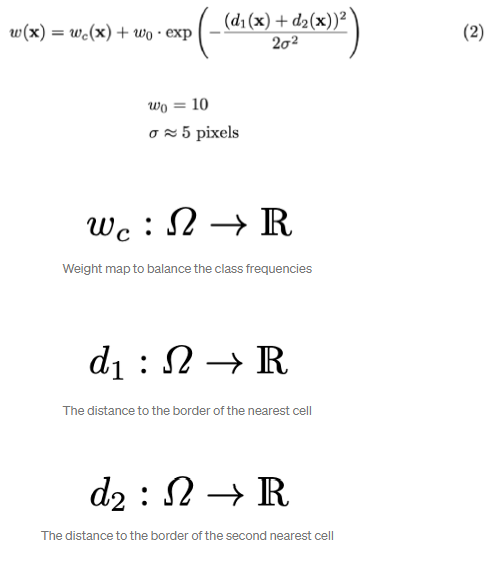

# 3. Training

입력 이미지와 segmentation map은 SGD를 통해 사용된다. 크로스 엔트로피 손실 함수와 최종 feature map에 대한 픽셀 단위 소프트 맥스를 결합하여 energy function이 계산된다.   

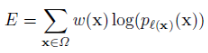  

* $E$ : energy function 
* $p(x)$ : softmax 
* $l$ : true label of each pixel 
* $w$ : weight map, 각각 ground truth segmentation에 대해 w를 계산하여 네트워크가 인접한 객체들 사이의 separation border를 알아낼 수 있도록 한다. 또한 초기 weight의 설정이 중요하며 각각의 feature map이 대략적인 unit variance를 가지도록 설정되어야 한다.  

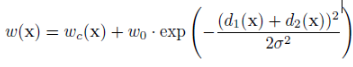  

* $w(x)$ : 각 픽셀마다의 weight 
* $wc$ : weight map to balance the class frequencies
* $d1$ : 가장 가까운 객체의 경계까지 거리 
* $d2$ : 두 번째로 가까운 객체의 경계까지의 거리  

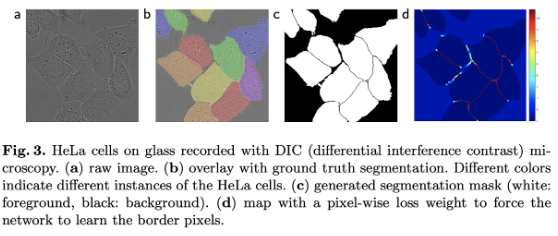

* Momentum : 0.99  
* Gaussian distribution 학습 파라미터 초기화

# 4. Summary

U-Net은 FCNs보다 확장된 개념의 Up-sampling과 Skip Architecture를 적용한 모델을 제안하였다.

결과적으로 U-Net의 구조는 아주 적은 양의 학습 데이터만으로 Data Augmentation을 활용하여 여러 Biomedical Image Segmentation 문제에서 우수한 성능을 보여주었다.